In [1]:
cd ~/qdpy-numpyro

/mnt/disk2/samarth/qdpy-numpyro


rth = 0.9
[[  0 200]
 [  0 201]]
Total multiplets: 2
rth = 0.97
Generating the Ritzwoller-Lavely polynomials for ell = 201 and jmax = 5
Generating the Ritzwoller-Lavely polynomials for ell = 200 and jmax = 5
Shape = (2, 6, 403)
rth = 0.97
rth = 0.97


nmult: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Max diff = 90.98267746458112
0 [-593.09439284 -589.89141855 -586.68185598 ...  483.9261471   487.13653751
  399.3440133 ]
1 [-588.70774386 -585.51244333 -582.31054142 ...    0.            0.
  -90.99961828]
num elements = 4030


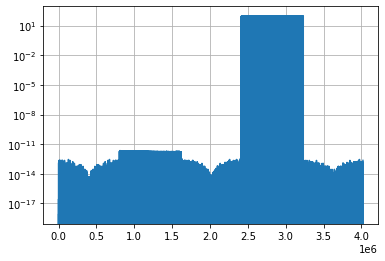

In [2]:
%run vorontsov_qdpy/mode_lister.py --nmin 0 --nmax 0 --lmin 200 --lmax 201
%run vorontsov_qdpy/precompute_ritzlavely.py
%run vorontsov_qdpy/generate_synthetic_eigvals.py --load_mults 1 --knot_num 5 --rth 0.97

plt.figure()
plt.semilogy(abs(sm_model.flatten() - sm_qdpt.flatten()))
plt.show()

In [3]:
%run vorontsov_qdpy/save_reduced_problem.py
%run vorontsov_qdpy/save_reduced_problem_M.py
%run vorontsov_qdpy/run_reduced_problem_model.py

rth = 0.97


JAX using: cpu
rth = 0.97


nmult: 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


(2, 10275)
(2, 10275, 2)
[ 0.01907192  0.00496713  0.02026428  0.01785718 -0.00062958  0.01474696]
rth = 0.97
rth = 0.97
JAX using: cpu
rth = 0.97


nmult: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


param_coeff = (3, 4, 2, 5, 5, 411)
cind_arr = [0 1 2 3]
rth = 0.97


 ell     |   Model       |    True       |    Diff       | Diff/sigma 
-----------------------------------------------------------------------
 201     |   436.87224   |   438.03475   |    -1.16251   |   -32.54187
 201     |    21.95791   |    20.05801   |     1.89990   |    40.96433
 201     |    -5.07128   |    -4.35099   |    -0.72028   |   -13.27914
-------------------------------------------------------------------
 200     |   436.87766   |   438.04030   |    -1.16265   |   -32.02342
 200     |    21.96010   |    20.05927   |     1.90083   |    40.76700
 200     |    -5.07069   |    -4.35053   |    -0.72016   |   -12.97974
-------------------------------------------------------------------
Total time taken for 2 modes = 9.953e-03 seconds


In [4]:
zfull = param_coeff @ true_params + fixed_part
zM = param_coeff_M @ true_params + fixed_part_M
bkm = param_coeff_bkm @ true_params + fixed_part_bkm
clp = get_clp(bkm)

mode_idx = -1
clp_200 = clp[mode_idx]

zfull_200 = zfull[mode_idx]
zM_200 = zM[mode_idx]
bkm_200 = bkm[mode_idx]
zfull_200_flat = jnp.reshape(zfull_200, (max_nbs*max_nbs*len_mmax), order='F')
zM_200_flat = jnp.reshape(zM_200, (max_nbs*max_nbs*len_mmax), order='F')
bkm_200_flat = jnp.reshape(bkm_200, (max_nbs*max_nbs*len_mmax), order='F')

sparse_idx_200 = sparse_idx[mode_idx]
sparseM_idx_200 = sparse_idx_M[mode_idx]

sparse_200_flat = jnp.reshape(sparse_idx_200, (max_nbs*max_nbs*len_mmax, 2), order='F')
sparseM_200_flat = jnp.reshape(sparseM_idx_200, (max_nbs*max_nbs*len_mmax, 2), order='F')


zf_dense = sparse.BCOO((zfull_200_flat, sparse_200_flat), shape=(dim_hyper, dim_hyper)).todense()
zMf_dense = sparse.BCOO((zM_200_flat, sparseM_200_flat), shape=(dim_hyper, dim_hyper)).todense()
bkm_dense = sparse.BCOO((bkm_200_flat, sparse_200_flat), shape=(dim_hyper, dim_hyper)).todense()
zf_diag = np.diag(zf_dense)
zMf_diag = np.diag(zMf_dense)

ev_200_V11 = np.sum(clp_200.conj() * (zM_200 * clp_200[:, NAX, :]).sum(axis=0), axis=0)

supmat = np.load("supmat_qdpt_200.npy").real
ev_200_eigh, evec_200 = jnp.linalg.eigh(supmat)
ev_200_eigh = eigval_sort_slice(ev_200_eigh/2./omega0_arr[-1], evec_200)[:401]

lmax_pjl = int(len_mmax//2)
dell = lmax_pjl - 200
ac1 = Pjl[-1] @ ev_200_V11/Pjl_norm[-1]
ac2 = Pjl[-1][:, dell:-dell] @ ev_200_eigh/Pjl_norm[-1]
print(ac1*GVARS.OM*1e6)
print(ac2*GVARS.OM*1e6)

[ 0.43688713  0.02194288 -0.0050643 ]
[ 0.43688539  0.02194333 -0.00506275]


In [ ]:
def plot_fullmat(mat):
    vmax = abs(mat).max()
    fig = plt.figure()
    plt.imshow(mat, cmap='seismic', vmax=vmax/100000, vmin=-vmax/100000)
    return fig

fig = plot_fullmat(zMf_dense)
fig.show()

In [ ]:
plt.figure()
for i in range(5):
    plt.semilogy(abs(clp[0, 4, :]), label=i)
plt.legend()
plt.show()

### Comparing supermatrices with the ones constructed using qdPy

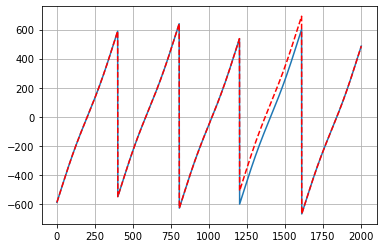

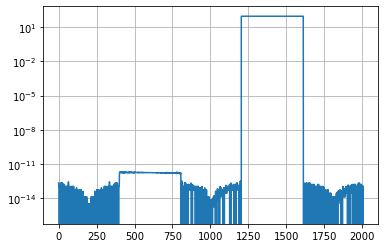

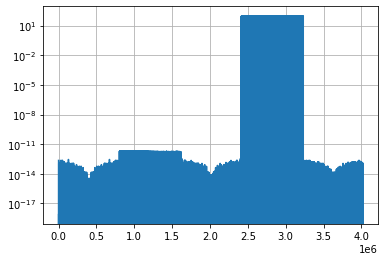

max diff = 90.982677464581
count of diff > 1e-11 = 409


<ipython-input-5-06522c3fd8e5>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


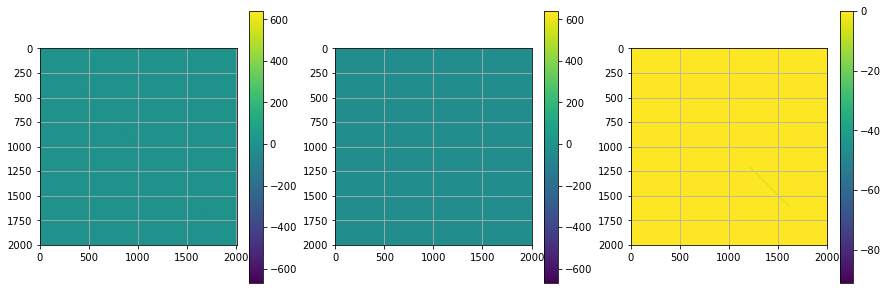

In [5]:
supmat = np.load("supmat_qdpt_200.npy").real
matsize = supmat.shape[0]
qdpt_diag = np.diag(supmat)
plt.figure()
plt.plot(zf_diag[:matsize])
plt.plot(qdpt_diag, '--r')
plt.show()

plt.figure()
plt.semilogy(abs(zf_diag[:matsize] - qdpt_diag))
plt.show()

plt.figure()
plt.semilogy(abs(zf_dense[:matsize, :matsize].flatten() - supmat.flatten()))
plt.show()

matdiff = abs(supmat - zf_dense[:matsize, :matsize])
thresh = 1e-11
print(f"max diff = {matdiff.max()}")
print(f"count of diff > {thresh} = {(matdiff>thresh).sum()}")

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs = axs.flatten()
im1 = axs[0].imshow(zf_dense[:matsize, :matsize])
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(supmat)
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(zf_dense[:matsize, :matsize] - supmat)
plt.colorbar(im2, ax=axs[2])
fig.show()



## Testing out the compare_model function

In [ ]:
mult_idx = -1
z0 = param_coeff_M[mult_idx] @ true_params + fixed_part_M[mult_idx]
zfull = param_coeff[mult_idx] @ true_params + fixed_part[mult_idx]
bkm = param_coeff_bkm @ true_params + fixed_part_bkm

for midx in range(nmults):
    bkm = jidx_update(bkm, 
                      jidx[midx, :, :, :],
                      -1.0*bkm[midx]/dom_dell_jax[midx])
                         
clp = get_clp(bkm)[mult_idx]
bkm = bkm[mult_idx]
                        
omegaref = omega0_arr_jax[mult_idx]
ell0 = ell0_arr_jax[mult_idx]

z1 = zfull/2./omegaref - z0
_eigval0mult = get_eig_corr(clp, z0)*GVARS.OM*1e6
_eigval1mult = get_eig_corr(clp, z1)*GVARS.OM*1e6
_eigval_mult = _eigval0mult + _eigval1mult

Pjl_local = Pjl[mult_idx]

In [ ]:
plt.figure()
plt.plot(_eigval_mult[-10:], '--r')
plt.plot(Pjl_local[0, -10:], 'k')
plt.show()

plt.figure()
plt.plot(_eigval_mult[:10], '--r')
plt.plot(Pjl_local[0, :10], 'k')
plt.show()

### Explicit computation of eigenvalues

In [ ]:
def eigval_sort_slice(eigval, eigvec):
    eigbasis_sort = np.zeros(len(eigval), dtype=int)
    for i in range(len(eigval)):
        eigbasis_sort[i] = np.argmax(abs(eigvec[i]))
    return eigval[eigbasis_sort]

ell0 = 200
omegaref = omega0_arr[-1]
supmat = np.load(f"supmat_qdpt_{ell0}.npy").real


eigvals, eigvecs = np.linalg.eigh(supmat)
eigvals = eigval_sort_slice(eigvals, eigvecs)
eigvals = eigvals[:2*ell0+1]/2./omegaref*GVARS.OM*1e6

supmat2 = zf_dense[:matsize, :matsize]
eigvals2, eigvecs2 = np.linalg.eigh(supmat2)
eigvals2 = eigval_sort_slice(eigvals2, eigvecs2)
eigvals2 = eigvals2[:2*ell0+1]/2./omegaref*GVARS.OM*1e6

acoeffs = (Pjl[-1][:, :2*ell0+1] @ eigvals)/Pjl_norm[-1]
acoeffs2 = (Pjl[-1][:, :2*ell0+1] @ eigvals2)/Pjl_norm[-1]
print(acoeffs)
print(acoeffs2)

In [ ]:
supmat

In [ ]:
GVARS.omega0_arr

In [ ]:
np.diag(supmat)[:10]

In [ ]:
Pjl[-1][0, :].max()

In [ ]:
Pjl.shape

In [ ]:
plt.figure()
plt.plot(Pjl[-1, 0, :])